### **Synthetic Time-Series Data Generation**

**Introduce Anomalies**

Some common types of anomalies:
1. Point Anomalies: Sudden spikes or drops in the data.
2. Contextual Anomalies: Anomalies that are only considered unusual in a specific context (e.g., a temperature reading that is high for winter but normal for summer).
3. Collective Anomalies: A series of data points that collectively deviate from the expected pattern.

The Silhouette Score ranges from -1 to 1, where a score closer to 1 indicates better clustering quality. A score of 0 suggests overlapping clusters, and a negative score indicates that a sample might have been assigned to the wrong cluster.

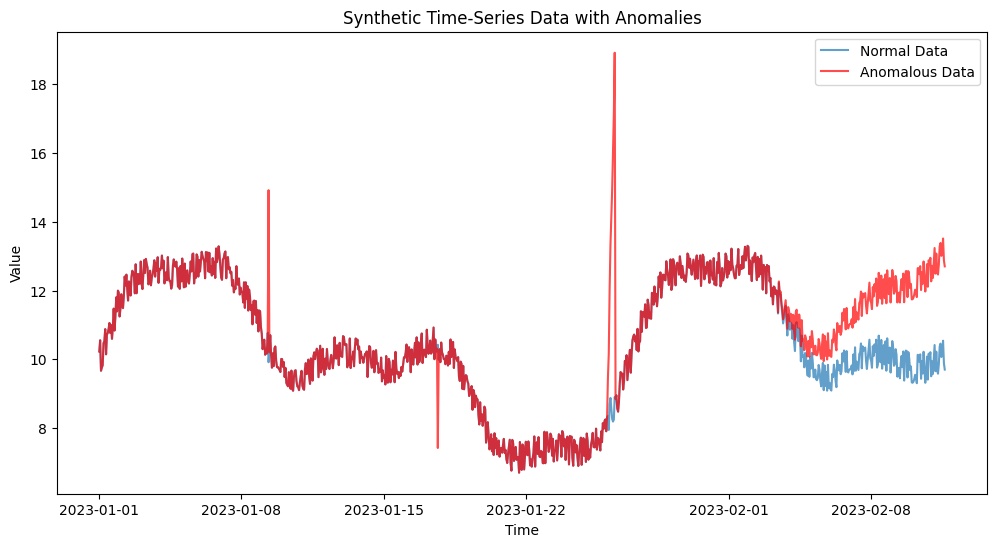

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#generate custom noise without using predefined distributions.
def custom_noise(size, amplitude=1):
    return amplitude * (np.random.rand(size) * 2 - 1)

#generate synthetic time series data without using predefined distributions
def generate_synthetic_data(n_points=1000, freq='h'):
    
    # Create time index
    time_index = pd.date_range(start='2023-01-01', periods=n_points, freq=freq)
    
    # Generate base pattern (e.g., combination of sine waves)
    t = np.linspace(0, 10, n_points)
    base_pattern = 10 + 2 * np.sin(t) + 1.5 * np.sin(2*t) + 0.5 * np.sin(5*t)
    
    # Add custom noise
    noise = custom_noise(n_points, amplitude=0.5)
    normal_data = base_pattern + noise
    
    # Create DataFrame for normal data
    normal_series = pd.DataFrame(data=normal_data, index=time_index, columns=['Normal'])
    
    # Generate anomalies
    anomalous_data = normal_data.copy()
    
    # Point anomalies
    anomalous_data[200] += 5  # Spike
    anomalous_data[400] -= 3  # Drop
    
    # Collective anomaly
    anomalous_data[600:610] += np.linspace(0, 10, 10)  # Gradual increase
    
    # Trend shift
    anomalous_data[800:] += np.linspace(0, 3, n_points-800)  # Upward trend
    
    # Create DataFrame for anomalous data
    anomalous_series = pd.DataFrame(data=anomalous_data, index=time_index, columns=['Anomalous'])
    
    # Combine normal and anomalous data
    combined_series = pd.concat([normal_series, anomalous_series], axis=1)
    
    return combined_series

# Generate the dataset
data = generate_synthetic_data(n_points=1000)

# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['Normal'], label='Normal Data', alpha=0.7)
plt.plot(data['Anomalous'], label='Anomalous Data', color='red', alpha=0.7)
plt.title('Synthetic Time-Series Data with Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

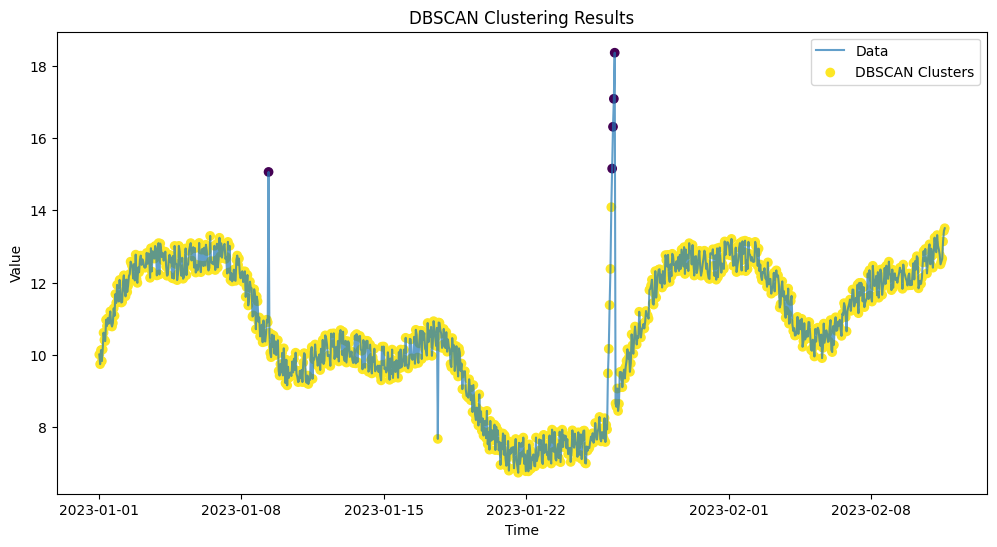

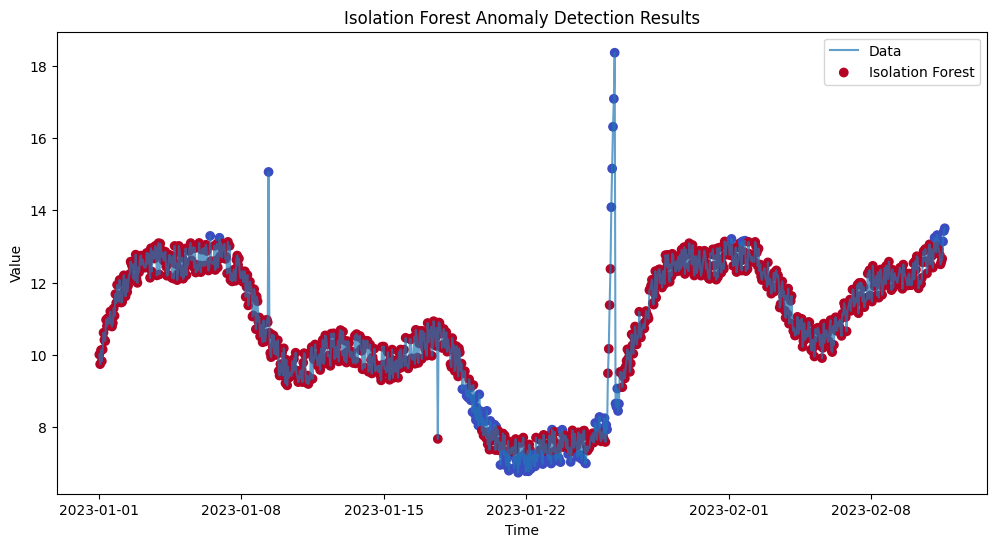

DBSCAN detected anomalies: 5
Isolation Forest detected anomalies: 100
DBSCAN Silhouette Score: 0.621
Isolation Forest Silhouette Score: 0.416


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Generate the dataset
data = generate_synthetic_data(n_points=1000)

# Prepare data for DBSCAN and Isolation Forest
X = data['Anomalous'].values.reshape(-1, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Implement DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Implement Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest_labels = iso_forest.fit_predict(X_scaled)

# Add results to the dataframe
data['DBSCAN'] = dbscan_labels
data['IsolationForest'] = iso_forest_labels

# Visualize DBSCAN results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Anomalous'], label='Data', alpha=0.7)
plt.scatter(data.index, data['Anomalous'], c=data['DBSCAN'], cmap='viridis', label='DBSCAN Clusters')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Visualize Isolation Forest results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Anomalous'], label='Data', alpha=0.7)
plt.scatter(data.index, data['Anomalous'], c=data['IsolationForest'], cmap='coolwarm', label='Isolation Forest')
plt.title('Isolation Forest Anomaly Detection Results')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Print summary of detected anomalies
print("DBSCAN detected anomalies:", sum(dbscan_labels == -1))
print("Isolation Forest detected anomalies:", sum(iso_forest_labels == -1))

# Evaluate the performance
from sklearn.metrics import silhouette_score

# For DBSCAN
dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)
print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")

# For Isolation Forest (treat it as a binary classification)
iso_forest_silhouette = silhouette_score(X_scaled, iso_forest_labels)
print(f"Isolation Forest Silhouette Score: {iso_forest_silhouette:.3f}")